## Tutorial - Comparing explanation methods

This tutorial demonstrates how to use the library to compare different explanations method with several different evaluation criteria. We use a Resnet-18 model and CalTech-256 dataset to showcase the library's functionality.



In [51]:
# Mount Google Drive. #remove
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

# Install packages. #remove
!pip install captum opencv-python torch==1.8.0 torchvision==0.9.0

# Imports general.
import sys
import warnings
import gc
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import captum
from torchvision import transforms
from tqdm import tqdm
from captum.attr import *
import random

# Import package.
sys.path.append('/content/drive/MyDrive/Projects/xai_quantification_toolbox')
import quantus

# Notebook settings.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
warnings.filterwarnings("ignore", category=UserWarning)
%load_ext autoreload
%autoreload 2

# Collect garbage.
gc.collect()
torch.cuda.empty_cache()

Mounted at /content/drive
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Caltech256 dataset.

In [2]:
# Load datasets and make loaders.
dataset = torchvision.datasets.Caltech256(root='./sample_data', 
                                          download=True,
                                          transform=transforms.Compose([transforms.Resize(256),
                                                                        transforms.CenterCrop((224, 224)),
                                                                        transforms.ToTensor(),
                                                                        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))]))
train_set, test_set = torch.utils.data.random_split(dataset, [27548, 3061])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

# Load a batch of inputs and outputs to use for evaluation.
x_batch, y_batch = iter(test_loader).next()
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

Files already downloaded and verified


### Train a ResNet18 model.

(or any other model of choice). 

In [ ]:
model = torchvision.models.resnet18(pretrained=True)
model.eval()

### Load gradient-based attributions.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


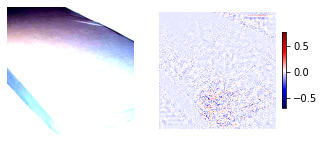

In [61]:
# Load attributions and plot them. 
a_batch = quantus.explain(model, 
                          x_batch, 
                          y_batch, 
                          explanation_func="IntegratedGradients",
                          **{"normalize": True})

# Plot examplary explanations!
index = random.randint(0, len(x_batch)-1)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
axes[0].imshow(x_batch[index].cpu().transpose(0, 1).transpose(1, 2)) #quantus.denormalize_image(, **{"img_size": 224})
exp = axes[1].imshow(a_batch[index], cmap="seismic"); fig.colorbar(exp, fraction=0.03, pad=0.05)
axes[0].axis("off"); axes[1].axis("off"); plt.show()

### Compare gradient-based explanation methods.

In [ ]:
# Specify XAI methods, either as a list (str) or as a dictionary with names of explantion methods(str) and either their pre-computed attributions (np.ndarray) or a explanation_func (callable).
explanation_methods = {"Saliency": explain, "IntegratedGradients": explain}

# Specify metrics and set (sensible) hyperparameters.
evaluation_metrics = {"Faithfulness correlation": FaithfulnessCorrelation(**{"subset_size": 32}),
                      "max-Sensitivity": MaxSensitivity(),
                      "Infidelity": Infidelity(**{"perturb_patch_sizes": list(np.arange(2, 8)),"img_size": 32, "nr_channels": 3})}
 
# Evaluate explanations!
results = evaluate(evaluation_metrics=evaluation_metrics,
                   explanation_methods=explanation_methods, 
                   model=model,
                   x_batch=x_batch.cpu().numpy(), 
                   y_batch=y_batch.cpu().numpy(), 
                   agg_func=np.mean,
                   **{"device": device, "img_size": 32, "normalize": True})

# Summarise in a dataframe.      
df = pd.DataFrame(results)
df

In [39]:
metric = FaithfulnessCorrelation()
metric.list_hyperparameters

{'nr_runs': 100,
 'perturb_baseline': 'black',
 'perturb_func': <function quantus.helpers.perturb_func.baseline_replacement_by_indices>,
 'similarity_func': <function quantus.helpers.similar_func.correlation_pearson>,
 'subset_size': 50}

In [40]:
metric.subset_size = 224 

In [38]:
scores = metric(model=model, x_batch=x_batch.cpu().numpy(), y_batch=y_batch.cpu().numpy(), a_batch=None, **{"explanation_func": "Saliency", "device": device})
scores

/content/drive/MyDrive/Projects/xai_quantification_toolbox/quantus/metrics/base.py:48: UserWarning: 

The Faithfulness Correlation metric is known to be sensitive to the choice of baseline value                 'perturb_baseline', size of subset |S| 'subset_size' and the number of runs for each input and explanation                 pair 'nr_runs'. 
Go over and select each hyperparameter of the SelectivityN metric carefully to avoid                 misinterpretation of scores. 
To view all relevant hyperparameters call list_hyperparameters method.
  time.sleep(2)
/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


In [61]:
# Load pre-trained ResNet18 model.
model = torchvision.models.resnet18(pretrained=True)

# Freeze model parameters
for params in model.parameters():
    params.requires_grad = False

# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Linear(fc_inputs, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(256, 10), 
    torch.nn.LogSoftmax(dim=1) # For using NLLLoss()
)
model.to(device)

# Define Optimizer and Loss Function
loss_func = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [48]:
def train_model(model, 
                data: torchvision.datasets, 
                device: torch.device, 
                epochs: int = 20,
                criterion: torch.nn = torch.nn.CrossEntropyLoss(), 
                optimizer: torch.optim =torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9), 
                evaluate: bool = False):
    """Train torch model."""
    
    model.train()
    
    for epoch in range(epochs):
        for images, labels in data:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)

            loss = criterion(logits, labels)
            model.zero_grad()
            loss.backward()
            optimizer.step()

            # Evaluate model!
            if evaluate:
                predictions, labels = evaluate_model(model, data, device)
                test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())
                print(f"Epoch {epoch+1}/{epochs} - train accuracy: {(100 * test_acc):.2f}%")

    return model

def evaluate_model(model, data, device):
    """Evaluate torch model."""
    model.eval()
    logits = torch.Tensor().to(device)
    targets = torch.LongTensor().to(device)

    with torch.no_grad():
        for images, labels in data:
            images, labels = images.to(device), labels.to(device)
            logits = torch.cat([logits, model(images)])
            targets = torch.cat([targets, labels])
    
    return torch.nn.functional.softmax(logits, dim=1), targets

In [ ]:
path_model_weights = "drive/MyDrive/Projects/xai_quantification_toolbox/nbs/resources/caltech256"

if pathlib.Path(path_model_weights).is_file():
    model.load_state_dict(torch.load(path_model_weights))
else:
    
    # Train and evaluate model.
    model = train_model(model=model.to(device),
                        data=train_loader,
                        device=device,
                        epochs=20,
                        criterion=torch.nn.CrossEntropyLoss().to(device),
                        optimizer=torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
                        evaluate=True)
    
    # Save model.
    torch.save(model.state_dict(), path_model_weights)

print(f"Model loaded.")
model.eval()
model.to(device)